In [16]:
import numpy as np
import xarray as xr
import scipy
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import os
import glob
import pandas as pd

In [17]:
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [4]:
# Setupcloseur PBSCluster (Casper)
ncores=4
nmem='16GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='UMSU0012', # Input your project ID here
    walltime='01:30:00', # Amount of wall time
    interface='mgt', # Interface to use
)

# Scale up
cluster.scale(ncores)

# Setup your client
client = Client(cluster)

/glade/work/elkoukah/conda-envs/mynpl/lib/python3.7/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 43291 instead
  f"Port {expected} is already in use.\n"


In [7]:
client

<Client: 'tcp://10.18.206.63:37941' processes=4 threads=16, memory=59.60 GiB>

In [3]:
areas = {'yampa':1468, 'east':748, 'animas':1819} #km^2
stids = {'yampa':'09239500', 'east':'09112500', 'animas':'09361500'}
tdelta = slice('1934-10-01', '2010-09-30')

# Reference evaluation

Evaluation of CLM5 streamflow and snow simulation

In [ ]:
from shapely.geometry import Polygon
def grid_polygon_intersect(lats, lons, res, geom):
    gridcells = [Polygon(((x-res, y-res),
                      (x-res, y+res),
                      (x+res, y+res),
                      (x+res,y-res),
                      (x-res, y-res))) for x,y in zip(lons, lats)]
    ngrd = len(gridcells)
    mask = np.zeros((ngrd,), dtype=int)
    print('searching for grid intersections ...')
    for ii in range(ngrd):
        mask[ii] = geom.intersects(gridcells[ii])
        # print('intersecting grid:', ii, 'out of', ngrd)
    print('intersecting grid total:', mask.sum(), 'out of', ngrd)
    return mask

def read_qobs(stids, tag, tdelta, areas, ):
    df = pd.read_csv('/glade/work/elkoukah/inputs/obs/CR/%s.txt'%stids[tag], skiprows=30, delimiter='\t', names=['org','stid','time','q','flag'])
    df = df[1:]
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')
    df['q'][df['q']=='Ice'] = np.nan
    daq = df['q'].astype(float).to_xarray()
    qobs = daq.sel(time=tdelta)*0.02832 #ft^3/s to m^3/s
    qobs = qobs.sel(time=~((qobs.time.dt.month == 2) & (qobs.time.dt.day == 29))) #drop leap day
    return qobs

import scipy.special as sps  
def route(da, shape=2.5, scale=1):
    nt = da.time.size
    t = np.arange(0, nt)
    y = t**(shape-1)*(np.exp(-t/scale) /  
                         (sps.gamma(shape)*scale**shape))
    q = np.convolve(y, da.data[:-1], mode='full')
    q = xr.DataArray(q[:nt-1], dims=('time',), coords={'time':da.time[:nt-1]}, name='Q')
    return q

from sklearn import linear_model
def calc_clim_sens(dprec_wy, davtemp_wy, dqobs_wy):
    X = np.stack([dprec_wy[1:],
                  davtemp_wy[1:],
                  dqobs_wy[:-1],
                 ])
    Y = dqobs_wy[1:]
    reg = linear_model.LinearRegression()
    reg.fit(X.T, Y)
    a, b, s = reg.coef_
    alpha = a/(1-s)
    beta = b/(1-s)
    return alpha, beta, s

def calc_nse(x,y):
    nse = 1 - np.sum((y-x)**2)/np.sum((x-x.mean())**2)
    return nse

def calc_fdc_slope(xx):
    y33 = np.percentile(xx, 33)
    y66 = np.percentile(xx, 66)
    slope = (np.log10(y66)-np.log10(y33))/(66-33)
    return slope

class Lyne_Hollick:

    def __init__(self, discharge):
        self.Q = discharge
        self.bflow = []
    
    def calc_bflow(self, alpha=.925, direction='f'):
        """
        Recursive digital filter for baseflow separation. Based on Lyne and Hollick, 1979.
    
        series : array of discharge measurements\n
        alpha : filter parameter\n
        direction : (f)orward or (r)everse calculation
        """
        # first looks to see if there has alread been a run
        if len(self.bflow) > 0:
            Q = np.array(self.bflow)
        else:
            Q = np.array(self.Q)
        f = np.zeros(len(Q))
        if direction[0] == 'f':
            for t in np.arange(1,len(Q)):
                # algorithm
                f[t] = alpha * f[t-1] + (1 + alpha)/2 * (Q[t] - Q[t-1])
                # to prevent negative values
                if Q[t] - f[t] > Q[t]:
                    f[t] = 0
        elif direction[0] == 'r':
            for t in np.arange(len(Q)-2, 1, -1):
                f[t] = alpha * f[t+1] + (1 + alpha)/2 * (Q[t] - Q[t+1])
                if Q[t] - f[t] > Q[t]:
                    f[t] = 0
        # adds the baseflow to self variables so it can be called recursively
        self.bflow = np.array(Q - f)
        # calls method again if multiple passes are specified
        if len(direction) > 1:
            self.calc_bflow(alpha, direction=direction[1:])
        
        return self.bflow

## Streamflow

In [ ]:
def preprocess(ds, vars=['QRUNOFF']):
    return ds[vars]

ds_nat = xr.open_dataset('/glade/work/elkoukah/inputs/obs/CR/nat_statemod_headwaters.nc')
sf = (12*1233)/(365*24*60**2) # af/month to m3/s

archivedir = '/glade/derecho/scratch/elkoukah/archive/'
streamflow_dict = {}
runoff_dict = {}
for tag in stids.keys():
    # Observations
    qobs = read_qobs(stids, tag, tdelta, areas)
    t = qobs.time
    ma = (t.dt.month==2)&(t.dt.day==29)
    qobs_t = qobs.sel(time=~ma)

    qobs_t_nat = ds_nat[tag].sel(time=tdelta)*sf
    
    # Simulations
    casename = 'I2000CLM51SP_%s_singlept_livneh.base_001' % tag
    ifiles = sorted(glob.glob(archivedir+casename+'/lnd/hist/*.h1.*'))
    dsh = xr.open_mfdataset(ifiles[:-1], parallel=True, preprocess=preprocess)
    qrof = dsh['QRUNOFF'].sel(lndgrid=0).compute()
    ## runoff routing
    print('routing runoff:', tag)
    rof = qrof*24*60**2
    discharge = route(rof)
    A = areas[tag]*10**6
    fc = (10**-3)*A/(24*60**2)
    qmdl = discharge*fc
    
    streamflow_dict[tag] = (qobs_t, qobs_t_nat, qmdl.sel(time=tdelta))
    runoff_dict[tag] = qrof.sel(time=tdelta)

In [19]:
meteo_wy_dict = {}
streamflow_wy_dict = {}
rof_dict = {}
cols = ['alpha_obs','beta_obs', 'sigma_obs', 'rratio_obs', 
        'alpha_mdl','beta_mdl', 'sigma_mdl', 'rratio_mdl',
        'nse_dd', 'nse_wy', 'trend_obs', 'trend_mdl',
        'bflow_index_obs', 'bflow_index_mdl', 'r2_wy', 'fdc_obs', 'fdc_sim']
rows = stids.keys()
nrow = len(rows)
ncol = len(cols)
df_metrics = pd.DataFrame(np.full((nrow,ncol),np.nan), columns=cols, index=rows)
for tag in stids.keys():
    # meteo variables
    metfile = '/glade/derecho/scratch/elkoukah/inputs/ucrb/headwaters/%s/%s_livneh_1915-2018.nc'%(tag,tag)
    ds_met = xr.open_dataset(metfile)
    ds_met_tdelta = ds_met.sel(time=tdelta).isel(lat=0,lon=0)
    prec = ds_met_tdelta['prec']
    avtemp = (ds_met_tdelta['tmax']+ds_met_tdelta['tmin'])/2
    prec_wy = prec.resample(time='A-SEP').mean()
    avtemp_wy = avtemp.resample(time='A-SEP').mean()
    dprec_wy = (prec_wy-prec_wy.mean().data)/prec_wy.mean().data
    davtemp_wy = avtemp_wy-avtemp_wy.mean().data

    # streamflow
    qobs_t, qobs_t_nat, qmdl = streamflow_dict[tag]
    qobs_wy = qobs_t_nat.sel(time=tdelta).resample(time='A-SEP').mean()
    dqobs_wy = (qobs_wy-qobs_wy.mean().data)/qobs_wy.mean().data
    qmdl_wy = qmdl.resample(time='A-SEP').mean()
    dqmdl_wy = (qmdl_wy-qmdl_wy.mean().data)/qmdl_wy.mean().data
    
    # runoff
    rof_mdl = runoff_dict[tag]*24*60**2 #mm/day
    rof_mdl_wy = rof_mdl.resample(time='A-SEP').mean()
    drof_mdl_wy = (rof_mdl_wy-rof_mdl_wy.mean().data)/rof_mdl_wy.mean().data

    # climate sensitivity
    alpha_obs, beta_obs, s_obs = calc_clim_sens(dprec_wy.data, davtemp_wy.data, dqobs_wy.data)
    alpha_sim, beta_sim, s_sim = calc_clim_sens(dprec_wy.data, davtemp_wy.data, drof_mdl_wy.data)

    # runoff ratio
    rof_obs = qobs_t_nat/(areas[tag]*10**6)*1000*24*60**2 #mm/day
    rratio_obs = rof_obs.mean('time').data/prec.mean('time').data
    rratio_sim = rof_mdl.mean('time').data/prec.mean('time').data

    # NSE
    nse_dd = calc_nse(qobs_t.data, qmdl.data)
    nse_wy = calc_nse(qobs_wy.data, qmdl_wy.data)

    # R2
    r2_wy = np.corrcoef(qobs_wy, qmdl_wy)[0,1]

    # Trends
    tpct_obs = np.polyfit(np.arange(dqobs_wy.size)+1, dqobs_wy.data[:, None]*100, 1)
    tpct_sim = np.polyfit(np.arange(dqobs_wy.size)+1, dqmdl_wy.data[:, None]*100, 1)

    # FDC slope
    robs_mon = rof_obs.resample(time='1M').mean()
    rmdl_mon = rof_mdl.resample(time='1M').mean()
    fdc_obs = calc_fdc_slope(robs_mon)
    fdc_mdl = calc_fdc_slope(rmdl_mon)
    
    # baseflow index
    lh_obs = Lyne_Hollick(qobs_t.data)
    bflow_obs = lh_obs.calc_bflow(direction='frf')
    bflow_index_obs = bflow_obs.mean()/qobs_t.mean().data
    lh_mdl = Lyne_Hollick(qmdl.data)
    bflow_mdl = lh_mdl.calc_bflow(direction='frf')
    bflow_index_mdl = bflow_mdl.mean()/qmdl.mean().data
    
    
    
    df_metrics.loc[tag] = [alpha_obs, beta_obs, s_obs, rratio_obs,
                           alpha_sim, beta_sim, s_sim, rratio_sim,
                           nse_dd, nse_wy, tpct_obs[0][0], tpct_sim[0][0],
                           bflow_index_obs, bflow_index_mdl, r2_wy, fdc_obs, fdc_mdl
                          ]
    
    meteo_wy_dict[tag] = (prec_wy, avtemp_wy)
    streamflow_wy_dict[tag] = (qobs_wy, qmdl_wy)
    rof_dict[tag] = (rof_obs, rof_mdl)

In [37]:
df_metrics.to_csv('./data/df_metrics_nat_flow.csv')

## Snow

In [22]:
ds_stations = xr.open_dataset('/glade/work/elkoukah/inputs/obs/snowPillowSWE_westernNA_level2_ncc.nc')
gdf = gpd.read_file('/glade/work/elkoukah/inputs/domain/shapefile/mendoza15_ucrb_subcat.shp')

In [23]:
ifiles = sorted(glob.glob('/glade/work/elkoukah/inputs/obs/swe/4km_SWE_Depth_WY*'))
ds_ua = xr.open_mfdataset(ifiles, parallel=True)

In [24]:
res = 0.02

In [ ]:
swe_obs_dict = {}
for tag in stids.keys():
    gdf_tag = gdf[gdf['layer']==tag]
    geom_tag = gdf_tag.geometry
    # Stations obs
    lons, lats = ds_stations['longitude'][0].data, ds_stations['latitude'][0].data
    lons[np.isnan(lons)] = 0.0
    lats[np.isnan(lats)] = 0.0
    mask = grid_polygon_intersect(lats, lons, res, geom_tag)
    ds_tag = ds_stations.sel(sites=(mask>0))
    time = pd.date_range('1960-10-01','2019-09-01')
    datenum = ds_tag['date_matlab'][:,0,:].data.ravel()
    swel2 = ds_tag['swe_level2'].data.transpose(1,0,2)
    swel2 = swel2.reshape(-1,59*366)
    swel2 = swel2[:, ~np.isnan(datenum)]
    swel2_stations = xr.DataArray(swel2, dims=('sites', 'time'), 
                                  coords={'time':time, 'sites':np.where(mask)[0]}, name='SWE')

    # Gridded obs
    xmin, ymin, xmax, ymax = gdf_tag.bounds.values[0]
    ds_swe_box = ds_ua.sel(lat=slice(ymin-res,ymax+res), lon=slice(xmin-res,xmax+res)).compute()
    lons, lats = np.meshgrid(ds_swe_box.lon, ds_swe_box.lat)
    mask = grid_polygon_intersect(lats.ravel(), lons.ravel(), res, geom_tag)
    ds_swe_ngrd = ds_swe_box.stack(ngrd=('lat','lon'))
    ds_swe_mean = ds_swe_ngrd.sel(ngrd=(mask>0)).mean('ngrd')

    swe_obs_dict[tag] = (swel2_stations, ds_swe_mean)

In [26]:
def preprocess(ds, vars=['H2OSNO']):
    return ds[vars]
archivedir = '/glade/derecho/scratch/elkoukah/archive/'
swe_mdl_dict = {}
for tag in stids.keys():
    casename = 'I2000CLM51SP_%s_singlept_livneh.base_001' % tag
    ifiles = sorted(glob.glob(archivedir+casename+'/lnd/hist/*.h1.*'))
    dsh = xr.open_mfdataset(ifiles[:-1], parallel=True, preprocess=preprocess)
    mdl_swe = dsh['H2OSNO'].sel(lndgrid=0).compute()
    swe_mdl_dict[tag] = mdl_swe

In [27]:
# Snow cover days

In [28]:
idir = '/glade/derecho/scratch/elkoukah/inputs/NOAA_IMS/tmp/'
ncfiles = sorted(glob.glob(idir+'*.nc'))
ds_ims = xr.open_mfdataset(ncfiles, parallel=True)

In [ ]:
scfg_obs_dict = {}
for tag in stids.keys():
    gdf_tag = gdf[gdf['layer']==tag]
    geom_tag = gdf_tag.geometry
    xmin, ymin, xmax, ymax = gdf_tag.bounds.values[0]
    ds_box = ds_ims.sel(lat=slice(ymin-res,ymax+res), lon=slice(xmin-res,xmax+res)).compute()
    lons, lats = np.meshgrid(ds_box.lon, ds_box.lat)
    mask = grid_polygon_intersect(lats.ravel(), lons.ravel(), res, geom_tag)
    ds_ngrd = ds_box.stack(ngrd=('lat','lon')).sel(ngrd=(mask>0))
    scfg_obs = (ds_ngrd['IMS_Surface_Values']>=4).sum('ngrd')/ds_ngrd.dims['ngrd']
    scfg_obs_dict[tag] = scfg_obs

In [30]:
def preprocess(ds, vars=['FSNO']):
    return ds[vars]
archivedir = '/glade/derecho/scratch/elkoukah/archive/'
fsno_mdl_dict = {}
for tag in stids.keys():
    casename = 'I2000CLM51SP_%s_singlept_livneh.base_001' % tag
    ifiles = sorted(glob.glob(archivedir+casename+'/lnd/hist/*.h1.*'))
    dsh = xr.open_mfdataset(ifiles[:-1], parallel=True, preprocess=preprocess)
    mdl_fsno = dsh['FSNO'].sel(lndgrid=0).compute()
    fsno_mdl_dict[tag] = mdl_fsno

In [ ]:
# snow covered days
scd_dict = {}
for tag in stids.keys():
    fsno_tdelta = slice('2004-10-01', '2010-09-30')
    scfg_obs = scfg_obs_dict[tag]
    scd_obs = (scfg_obs.sel(time=fsno_tdelta)>=0.1).resample(time='A-SEP').sum()
    fsno_mdl = fsno_mdl_dict[tag]
    scd_mdl = (fsno_mdl.sel(time=fsno_tdelta)>=0.1).resample(time='A-SEP').sum()
    scd_dict[tag] = (scd_obs, scd_mdl)
    # print(scd_obs.mean(), scd_mdl.mean())
    print(scd_mdl.mean().data)

## plot

In [33]:
def calc_trend_line(data):
    x = np.arange(data.size)+1
    a, b = np.polyfit(x, data[:, None], 1)
    y = a*x + b
    return y

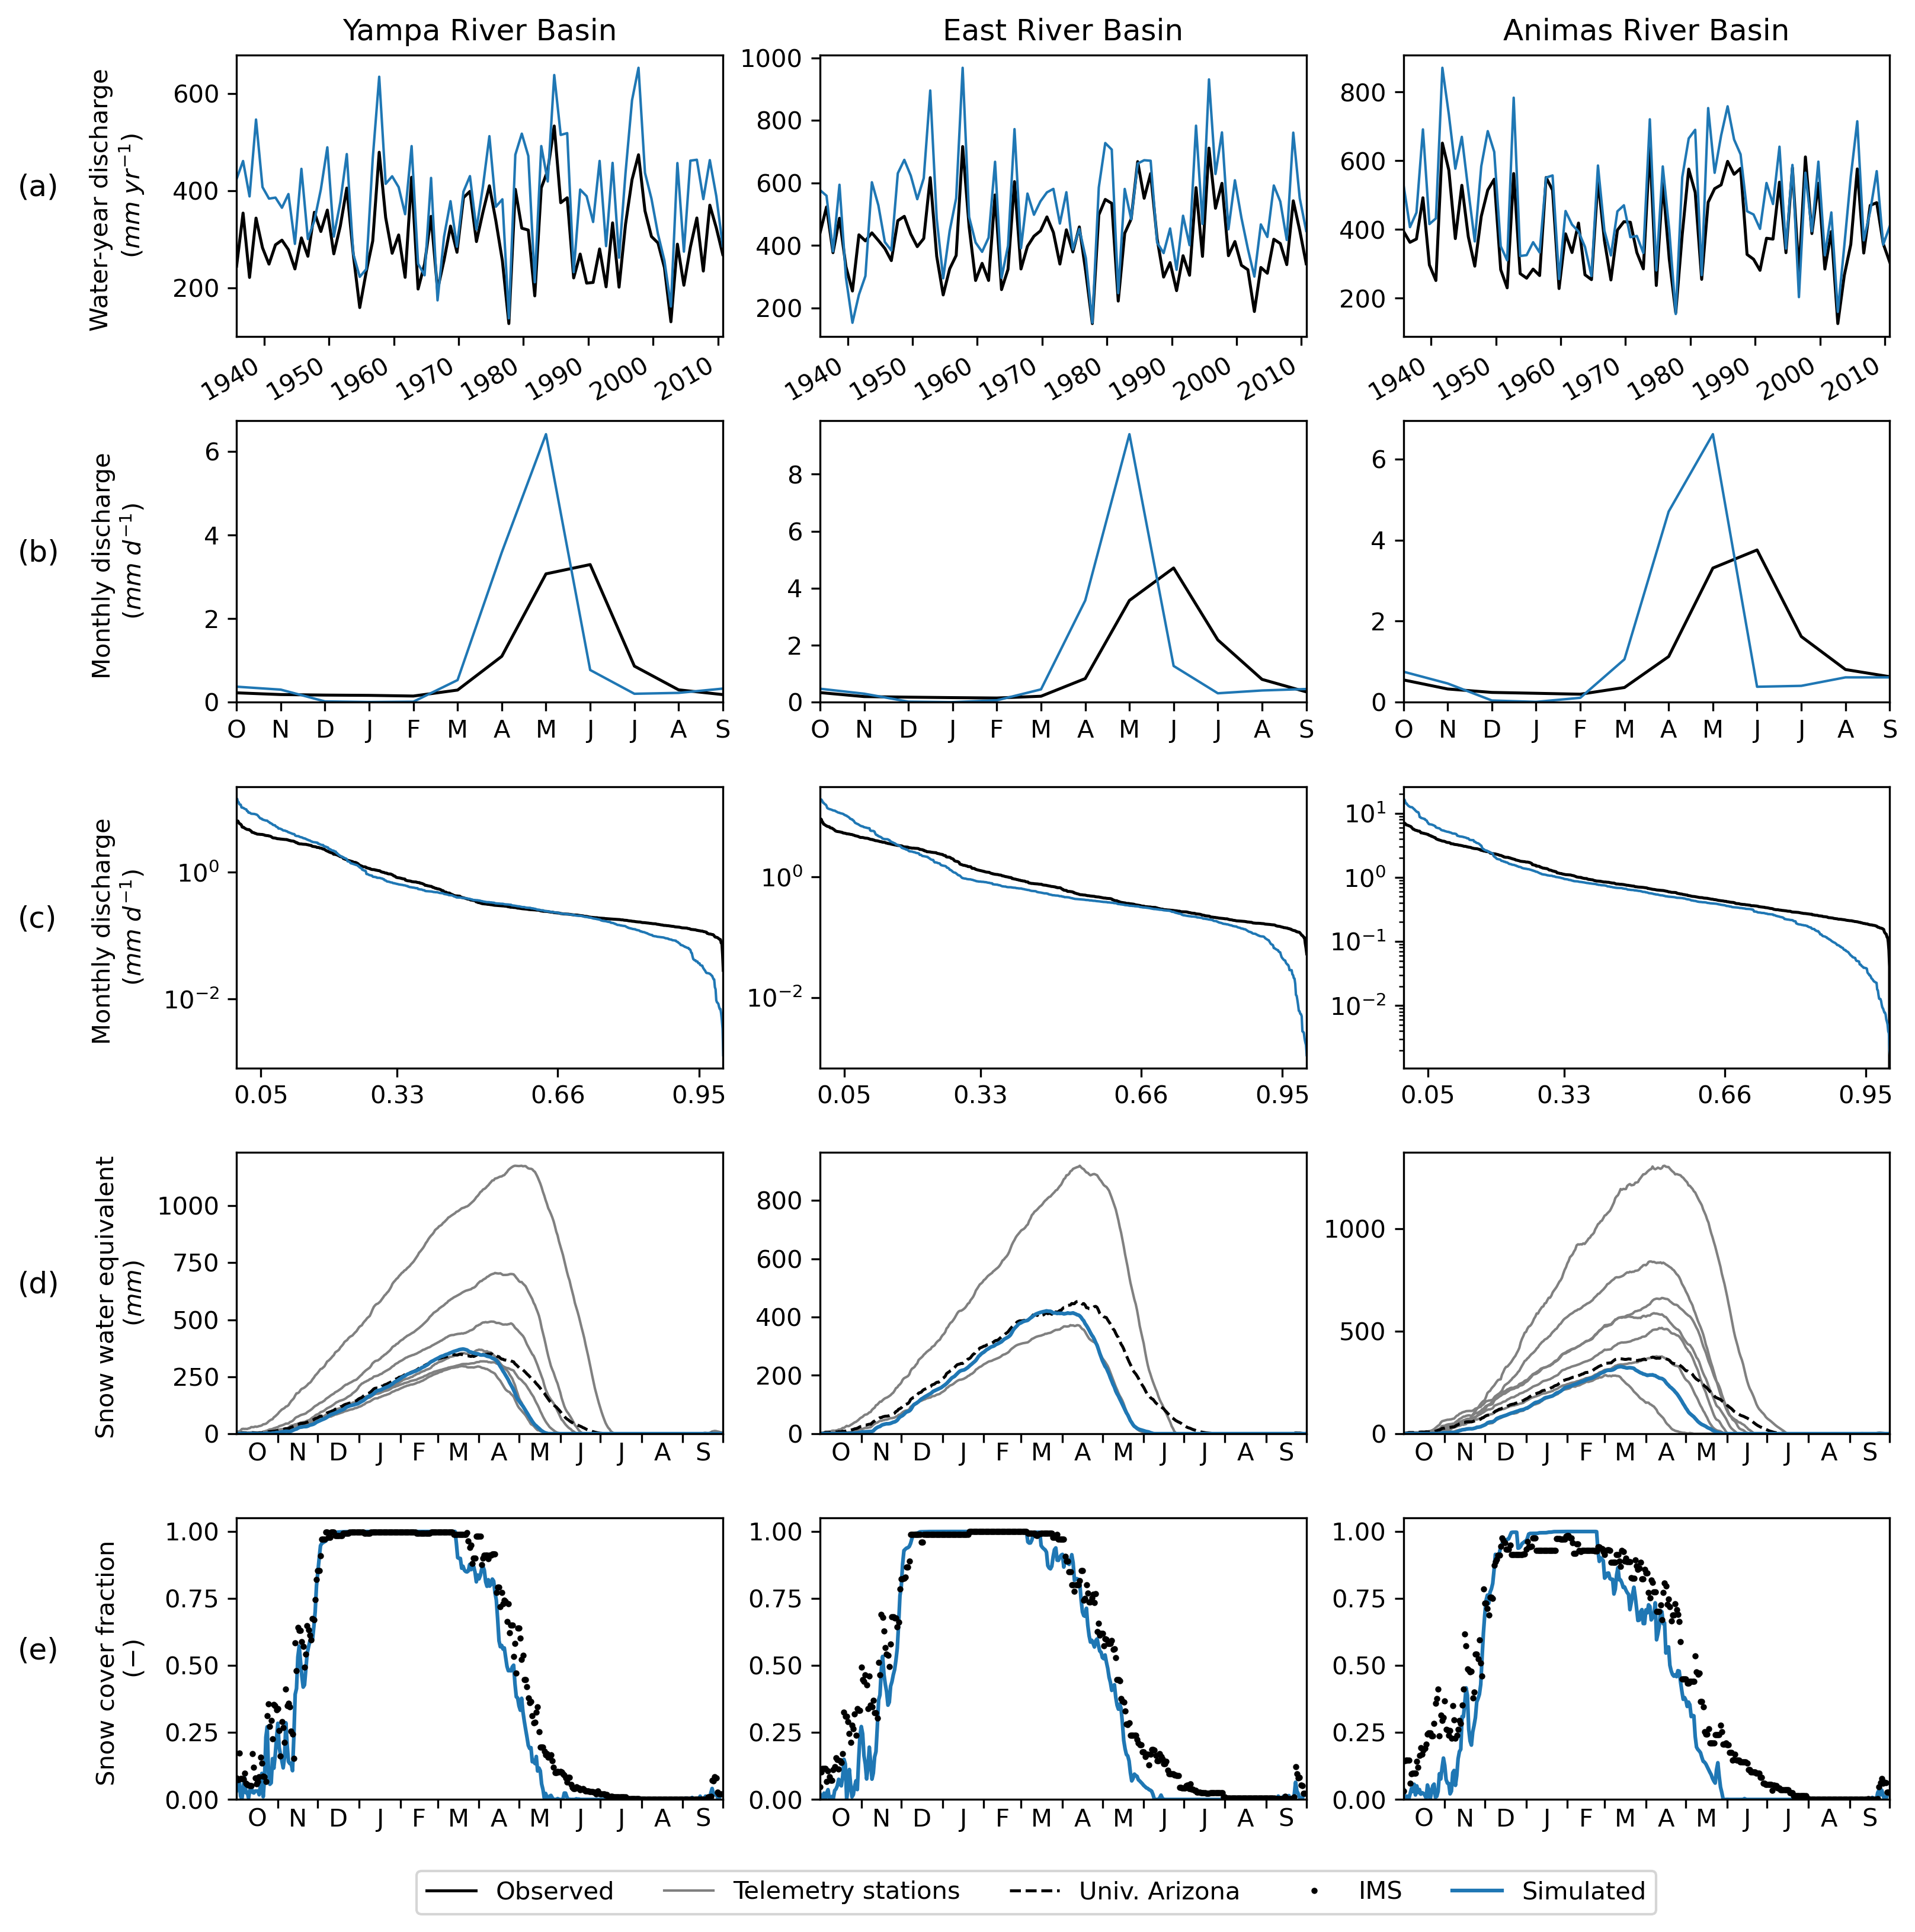

In [34]:
titles = ['Yampa River Basin', 'East River Basin', 'Animas River Basin']
fig, axes_all = plt.subplots(5,3,figsize=(12,13), dpi=300,
                             gridspec_kw={'hspace':0.3,'wspace':0.2})
# annual timeseries
coords = ((15,15),(15,5),(65,15),(75,5))
for bii, tag in enumerate(stids.keys()):
    ax = axes_all[0][bii]
    robs_dd, rmdl_dd = rof_dict[tag]
    qobs_wy = robs_dd.resample(time='A-SEP').mean()*365
    qmdl_wy = rmdl_dd.resample(time='A-SEP').mean()*365
    # qobs_wy, qmdl_wy = streamflow_wy_dict[tag]
    time = qobs_wy.time
    qmdl_wy['time'] = time
    qobs_wy.plot(c='k', ax=ax, lw=1.2, label='Observed discharge')
    qmdl_wy.plot(c='tab:blue', ax=ax, lw=1, label='Simulated discharge')
    # ax.plot(time, calc_trend_line(qobs_wy.data), c='k', lw=1.2, alpha=.7)
    # ax.plot(time, calc_trend_line(qmdl_wy.data), alpha=.7)
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.margins(x=0)
    ax.set_title(titles[bii])

# annual cycle (monthly)
months = np.arange(12)
idx = np.append(months[9:],months[:9])
for bii, tag in enumerate(stids.keys()):
    ax = axes_all[1][bii]
    # qobs_dd, qmdl_dd = streamflow_dict[tag]
    robs_dd, rmdl_dd = rof_dict[tag]
    qobs_dd = robs_dd.resample(time='1M').mean()
    qmdl_dd = rmdl_dd.resample(time='1M').mean()
    time = qobs_dd.time
    qmdl_dd['time'] = time
    qobs_annc = qobs_dd.groupby('time.month').mean()
    qmdl_annc = qmdl_dd.groupby('time.month').mean()
    
    ax.plot(qobs_annc.data[idx], c='k', lw=1.2, label='Observed discharge')
    ax.plot(qmdl_annc.data[idx], c='tab:blue', lw=1, label='Simulated discharge')
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks(months)
    ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',]);
    ax.margins(x=0)
    ax.set_ylim(0)

# FDC
for bii, tag in enumerate(stids.keys()):
    ax = axes_all[2][bii]
    # Monthly
    # robs_dd, rmdl_dd = rof_dict[tag]
    robs_dd, rmdl_dd = rof_dict[tag]
    xx, yy = robs_dd.resample(time='1M').mean(), rmdl_dd.resample(time='1M').mean()
    # ma = (xx.data<=0.01)+(yy.data<=0.01)
    ma = yy.data<=0.001
    N = (~ma).sum()
    X = np.arange(1,N+1)/N
    ax.plot(X, np.sort(xx.data[~ma])[::-1], c='k', lw=1.2, label='Observed discharge')
    ax.plot(X, np.sort(yy.data[~ma])[::-1], c='tab:blue', lw=1, label='Simulated discharge')
    xticks = np.array([5,33,66,95])/100
    ax.set_xticks(xticks)
    ax.set_yscale("log")
    ax.set_xlim(0,0.999)

# SWE annual cycle
t = np.arange(365)
ti = np.hstack([t[273:],t[:273]])
monthlength = np.array([31,30,31, 31,28,31,30,31,30,31,31,30])
for bii, tag in enumerate(stids.keys()):
    ax = axes_all[3][bii]
    mdl_swe = swe_mdl_dict[tag]
    swel2_stations, ds_swe_mean = swe_obs_dict[tag]
    swe_tdelta = slice('1995-10-01', '2010-09-30')
    yy = mdl_swe.sel(time=swe_tdelta).groupby('time.dayofyear').mean()
    xx_st = swel2_stations.sel(time=swe_tdelta).groupby('time.dayofyear').mean()
    xx_grd = ds_swe_mean['SWE'].sel(time=swe_tdelta).groupby('time.dayofyear').mean()

    ax.plot(xx_st.data.T[ti], color='grey', lw=1, label='Stations')
    # ax.plot(xx_st.mean('sites').data[ti], ls='--', color='k', lw=1, label='Stations average')
    ax.plot(xx_grd.data[ti], color='k', ls='--', lw=1.2, label='Univ. Arizona')
    ax.plot(yy.data[ti], color='tab:blue', label='Simulated')

    ax.margins(x=0)
    ax.set_ylim(0)
    ax.set_xticks(np.cumsum(monthlength))
    ax.set_xticklabels('')
    ax.set_xticks((monthlength*1.0/2.)+np.cumsum(np.append(0,monthlength)[0:12]), minor=True)
    ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',], minor=True);
    ax.tick_params('x',which='minor',length=0)

# Snow cover Fraction
for bii, tag in enumerate(stids.keys()):
    ax = axes_all[4][bii]
    
    fsno_tdelta = slice('2004-10-01', '2010-09-30')
    scfg_obs = scfg_obs_dict[tag].sel(time=fsno_tdelta)
    ma_time = (scfg_obs.time.dt.day==29)*(scfg_obs.time.dt.month==2)
    scfg_obs = scfg_obs.sel(time=(~ma_time))
    fsno_obs_doy = scfg_obs.groupby('time.dayofyear').mean()
    fsno_mdl = fsno_mdl_dict[tag].sel(time=fsno_tdelta)
    fsno_mdl_doy = fsno_mdl.groupby('time.dayofyear').mean()
    
    ax.plot(fsno_mdl_doy.data[ti], color='tab:blue', label='Simulated')
    ax.plot(fsno_obs_doy.data[ti], ls='', marker='.', markersize=3, color='k', lw=1.2, label='IMS')

    ax.margins(x=0)
    ax.set_ylim(0)
    ax.set_xticks(np.cumsum(monthlength))
    ax.set_xticklabels('')
    ax.set_xticks((monthlength*1.0/2.)+np.cumsum(np.append(0,monthlength)[0:12]), minor=True)
    ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',], minor=True);
    ax.tick_params('x',which='minor',length=0)

axes_all[0,0].set_ylabel('Water-year discharge \n($mm\;yr^{-1}$)')
axes_all[1,0].set_ylabel('Monthly discharge \n($mm\;d^{-1}$)')
axes_all[2,0].set_ylabel('Monthly discharge \n($mm\;d^{-1}$)')
axes_all[3,0].set_ylabel('Snow water equivalent \n($mm$)');
axes_all[4,0].set_ylabel('Snow cover fraction \n($-$)');
fig.align_ylabels(axes_all[:, 0])

h0, l0 = axes_all[0,0].get_legend_handles_labels()
h1, l1 = axes_all[-2,0].get_legend_handles_labels()
h2, l2 = axes_all[-1,0].get_legend_handles_labels()
h = [h0[0],h1[0],h1[-2],h2[-1],h1[-1]]
fig.legend(*(h, ['Observed', 'Telemetry stations', 'Univ. Arizona', 'IMS', 'Simulated']),
           loc='lower center', bbox_to_anchor=(0.5,.07), ncol=5,)

for ax,l in zip(axes_all[:,0], list('abcde')):
    ax.annotate('(%s)'%l, (-0.45,0.5), xycoords='axes fraction', fontsize=12)

# Runoff climate sensitivity

In [44]:
ifile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/headwaters_singlept/variance/ens_metrics.nc'
ds_metrics = xr.open_dataset(ifile)

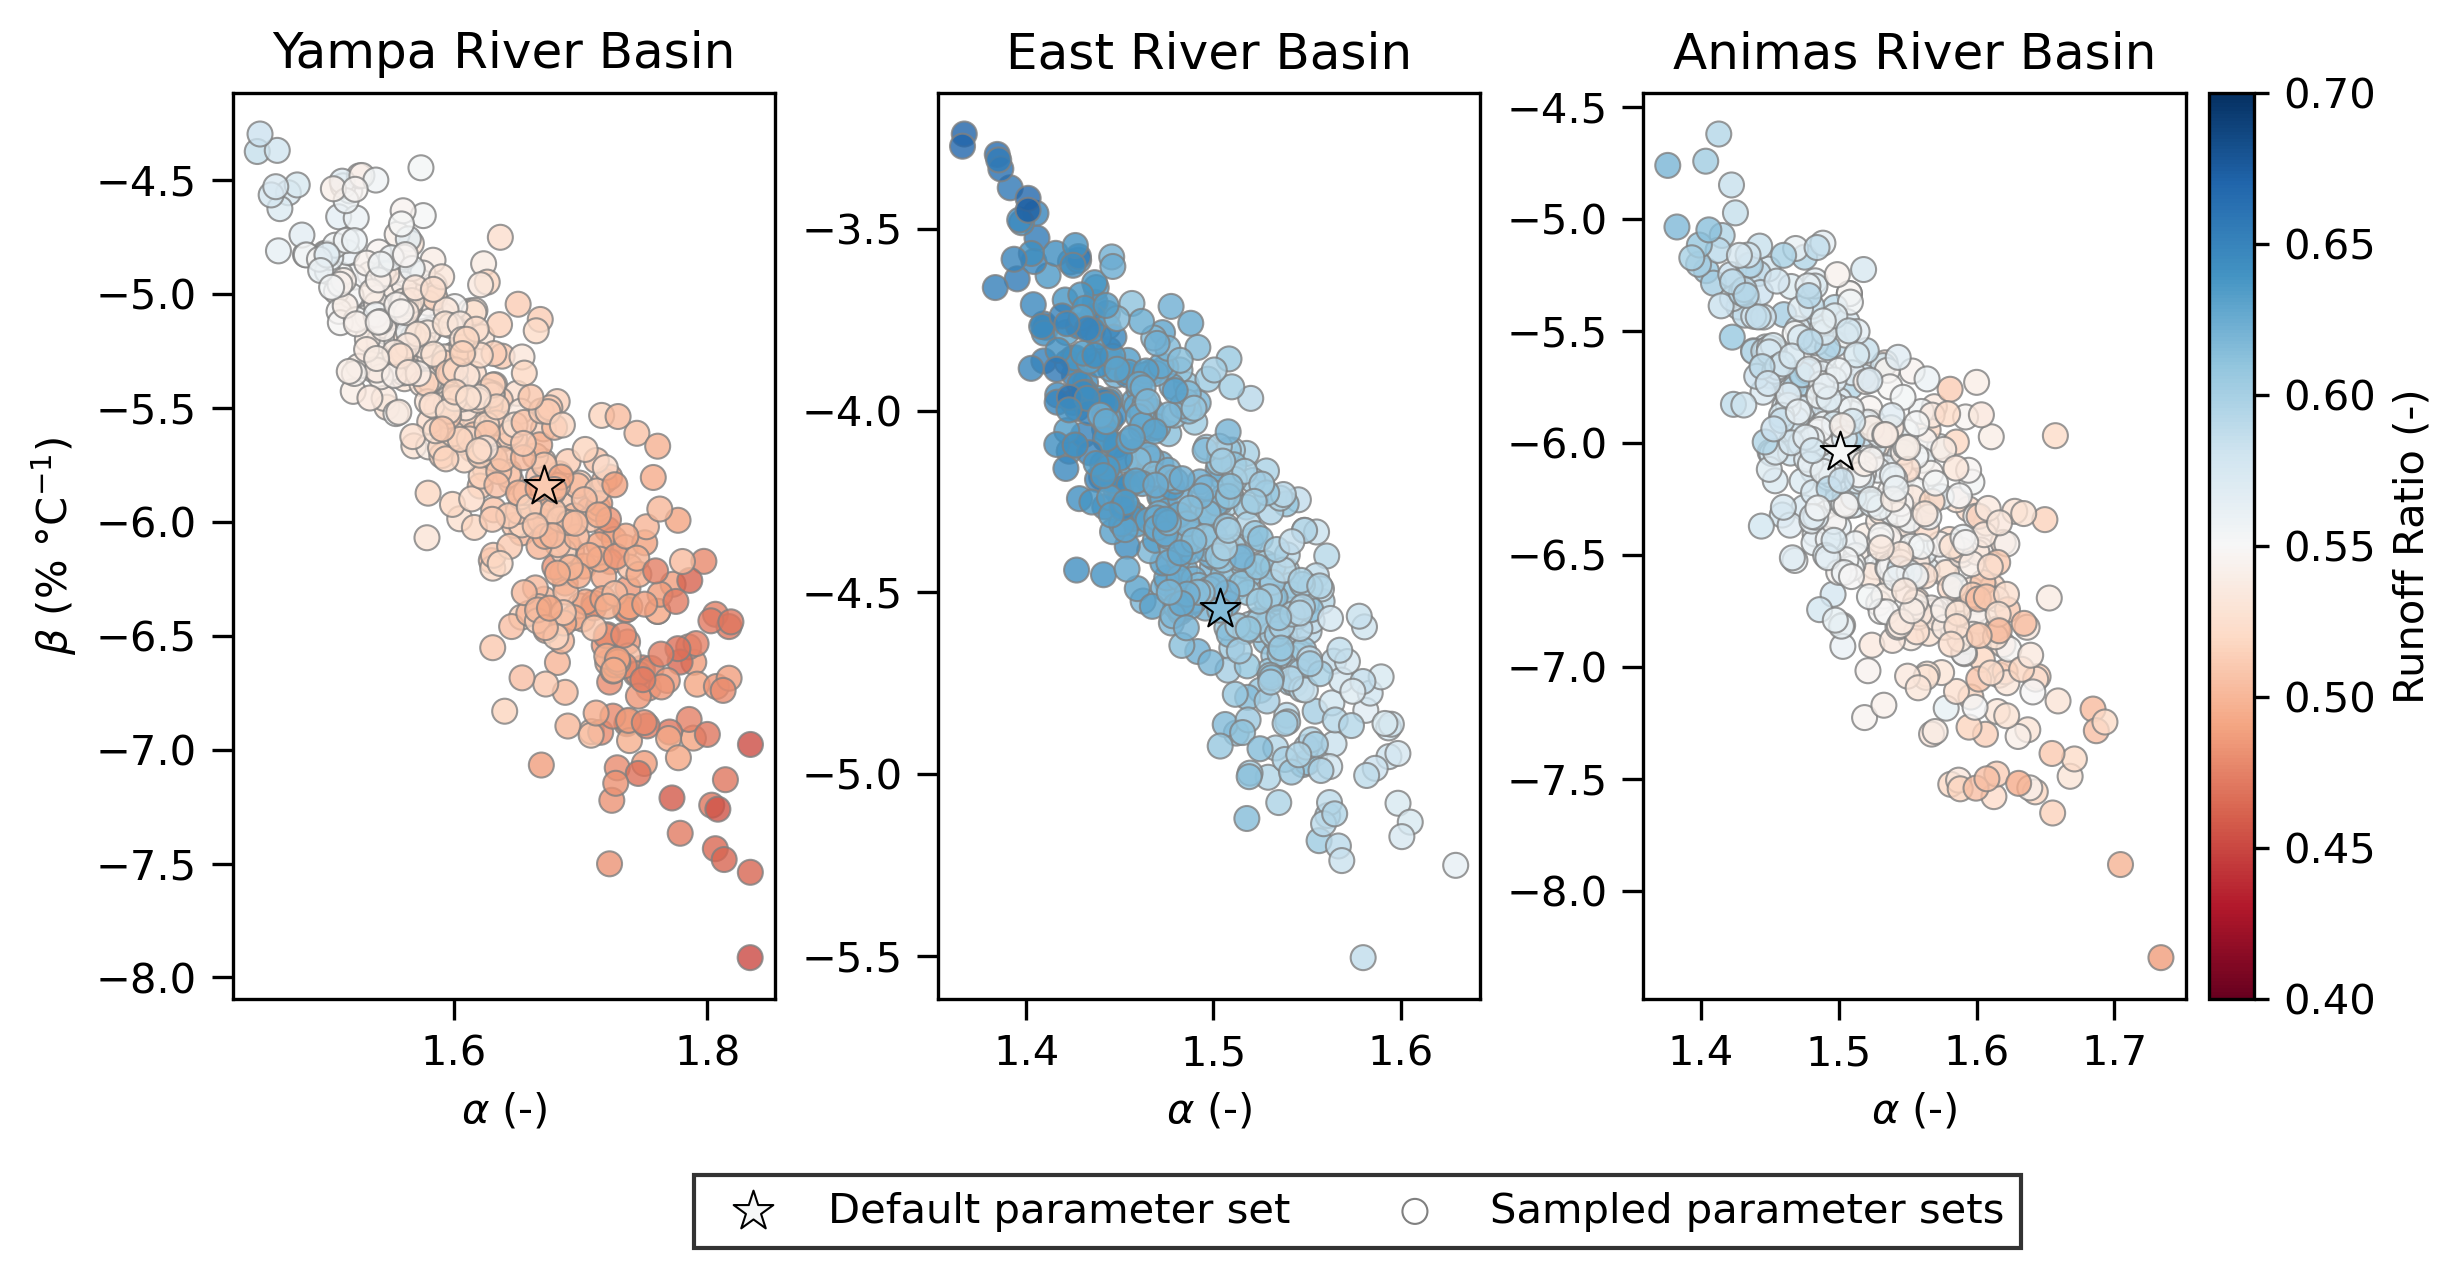

In [60]:
basins = ['yampa', 'east', 'animas']
metric_names = ['metric_alpha', 'metric_beta']
titles = ['Yampa River Basin', 'East River Basin', 'Animas River Basin']
fig, axes = plt.subplots(1,3,figsize=(10,4), dpi=300, gridspec_kw={'wspace':0.3})

# norm = mpl.colors.Normalize(vmin=20, vmax=60)
norm = mpl.colors.Normalize(vmin=0.4, vmax=0.7)
cmap = mpl.cm.get_cmap('RdBu')
# axes_r = axes.ravel()
dict_metrics = ds_metrics.isel(run=slice(0,512))
for bii in range(3):
    ax = axes[bii]        
    beta_mdl = dict_metrics[basins[bii]][:, 1]*100
    alpha_mdl = dict_metrics[basins[bii]][:, 0]
    rratio_mdl = dict_metrics[basins[bii]][:, 3]
    alpha_base = df_metrics.loc[basins[bii], 'alpha_mdl']
    beta_base = df_metrics.loc[basins[bii], 'beta_mdl']*100
    rratio_base = df_metrics.loc[basins[bii], 'rratio_mdl']
    rratio_obs = dict_sens[basins[bii]][2]
    alpha_obs = dict_sens[basins[bii]][0]
    beta_obs = dict_sens[basins[bii]][1]*100
    # alpha_ci, beta_ci = dict_sens_ci[basins[bii]][0], dict_sens_ci[basins[bii]][1]*100
    
    # xx = (alpha_mdl-alpha_obs)/alpha_obs * 100
    # yy = (beta_mdl-beta_obs)/beta_obs * 100
    xx = alpha_mdl
    yy = beta_mdl
    # cc = (rratio_mdl/rratio_obs - 1) * 100
    cc = rratio_mdl
    ax.scatter(x=xx[0], y=yy[0], c='None', edgecolor='grey', label='Sampled parameter sets', lw=.5,)
    ax.scatter(x=xx, y=yy, alpha=.8, c=cc, cmap=cmap, edgecolor='grey', lw=.5, norm=norm)
    # ax.scatter(alpha_obs, beta_obs, label='Observational estimates', color='None', edgecolor='k', lw=.5, marker='*', s=100)
    xx = alpha_base#(alpha_base-alpha_obs)/alpha_obs * 100
    yy = beta_base#(beta_base-beta_obs)/beta_obs * 100
    ax.scatter(x=xx, y=yy, label='Default parameter set', color=cmap(norm(rratio_base)), edgecolor='k', lw=.5, marker='*', s=100)
    ax.tick_params(length=5)
    ax.set_title(titles[bii])
    # ax.axvline(0, ls='--', color=c, zorder=-1, lw=.7)
    ax.set_xlabel(r'$\alpha$ (-)')
    # ax.set_xlabel(r'Bias in $\alpha$ (%)')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
fig.colorbar(sm, label='Runoff Ratio (-)', ax=axes, pad=0.01)
h,l = ax.get_legend_handles_labels()
fig.legend(h[::-1],l[::-1], loc='lower center', fancybox=False, bbox_to_anchor=(0.5,-0.1), ncol=3, edgecolor='k')
axes[0].set_ylabel(r'$\beta$ (% $\degree$C$^{-1}$)')
# axes[0].set_ylabel(r'Bias in $\beta$ (%)')
fig.savefig('figs/alpha_beta_rratio_v1.jpg', bbox_inches='tight')

# Variance SA

In [18]:
areas = {'yampa':1468, 'east':748, 'animas':1819} #km^2
stids = {'yampa':'09239500', 'east':'09112500', 'animas':'09361500'}
tdelta = slice('1934-10-01', '2010-09-30')

In [19]:
# Inputs

In [20]:
sa_dict = {}
vartot_dict = {}
for tag in ('yampa','east','animas'):
    safile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/headwaters_singlept/variance/%s_SA.nc'%tag
    ds_sa = xr.open_dataset(safile)
    vtotfile = '/glade/derecho/scratch/elkoukah/pipeline/%s_radial_variance_1.vtot.nc'%tag
    ds_vtot = xr.open_dataset(vtotfile)
    sa_dict[tag] = ds_sa
    vartot_dict[tag] = ds_vtot

metricfile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/headwaters_singlept/variance/ens_metrics_SA.nc'
sa_metrics = xr.open_dataset(metricfile)

my_paramfile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/headwaters_singlept/my_sel_params_round3.csv'
df_params = pd.read_csv(my_paramfile, index_col='name')

In [21]:
param_idx = np.array([0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]) # remove om_frac_sf
for tag in ('yampa','east','animas'):
    safile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/headwaters_singlept/variance/%s_SA.nc'%tag
    ds_sa = xr.open_dataset(safile).isel(ki=param_idx)
    sa_out = ds_sa.assign_coords({'sa':['Si','Sti']})
    sa_out.to_netcdf('paper_data_scripts/%s_Sti_Si.nc'%tag)

## Variance-average Sti

In [23]:
param_idx = np.array([0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19])
param_names = df_params.index
# basins = ['Yampa River', 'East River', 'Animas River']
basins = ['Yampa', 'East', 'Animas']
cols = ['basin','parameter','STi']
metrics = ['alpha','beta', 'sigma', 'rratio']
k = param_idx.size
nrow = k * len(basins)

si = 0 # Sti
dfplot_dict = {}
dfplot_interaction_dict = {}
for m in range(len(metrics)):
    dfi = pd.DataFrame(np.full((nrow, len(cols)), np.nan), columns=cols)
    dfi_interact = pd.DataFrame(np.full((nrow, len(cols)), np.nan), columns=cols)
    for i, tag in enumerate(('yampa','east','animas')):
        for j, ki in enumerate(param_idx):
            val = sa_metrics[tag][ki,si,m].data
            dfi.iloc[j+(k*i), :] = [basins[i], param_names[ki], val]
            
            val_interact = val - sa_metrics[tag][ki,1,m].data
            dfi_interact.iloc[j+(k*i), :] = [basins[i], param_names[ki], val_interact]
    dfplot_dict[metrics[m]] = dfi
    dfplot_interaction_dict[metrics[m]] = dfi_interact

vars = ['QRUNOFF','QOVER','QDRAI','EFLX_LH_TOT','QVEGT','QSOIL','FPSN','FSH']
for var in vars:
    dfi = pd.DataFrame(np.full((nrow, len(cols)), np.nan), columns=cols)
    dfi_interact = pd.DataFrame(np.full((nrow, len(cols)), np.nan), columns=cols)
    for i, tag in enumerate(('yampa','east','animas')):
        for j, ki in enumerate(param_idx):
            st_data = sa_dict[tag][var][ki,si,:,0]
            st_data_si = sa_dict[tag][var][ki,1,:,0]
            v_data = vartot_dict[tag][var][:,0]
            if var in ['None']: #['QRUNOFF','QOVER','QDRAI']:
                val = st_data.mean().data
            else:
                val = (st_data*v_data).sum().data/v_data.sum().data
                val_si = (st_data_si*v_data).sum().data/v_data.sum().data
            val_interact = val - val_si
            dfi.iloc[j+(k*i), :] = [basins[i], param_names[ki], val]
            dfi_interact.iloc[j+(k*i), :] = [basins[i], param_names[ki], val_interact]
            
    dfplot_dict[var] = dfi
    dfplot_interaction_dict[var] = dfi_interact

In [24]:
# plot

In [25]:
names_ordered = ['watsat_sf', 'sucsat_sf', 'hksat_sf', 'bsw_sf', 'e_ice', 'zbedrock_sf', 'FMAX', 'fff', 
                 'baseflow_scalar', 'interception_fraction', 'n_melt_coef', 'upplim_destruct_metamorph', 
                 'snowcan_unload_wind_fact', 'eta0_vionnet', 'd_max', 'cv', 'medlynslope', 'jmaxb0', 'kmax']
len(names_ordered)

19

In [26]:
import cmocean.cm as cmo

In [27]:
colors1 = np.stack([plt.cm.binary_r(np.linspace(0., 1, 128))[-1]]*15)
colors2 = cmo.amp(np.linspace(0, 1, 29))
colors = np.vstack((colors1, colors2))
mymap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', colors, N=39)

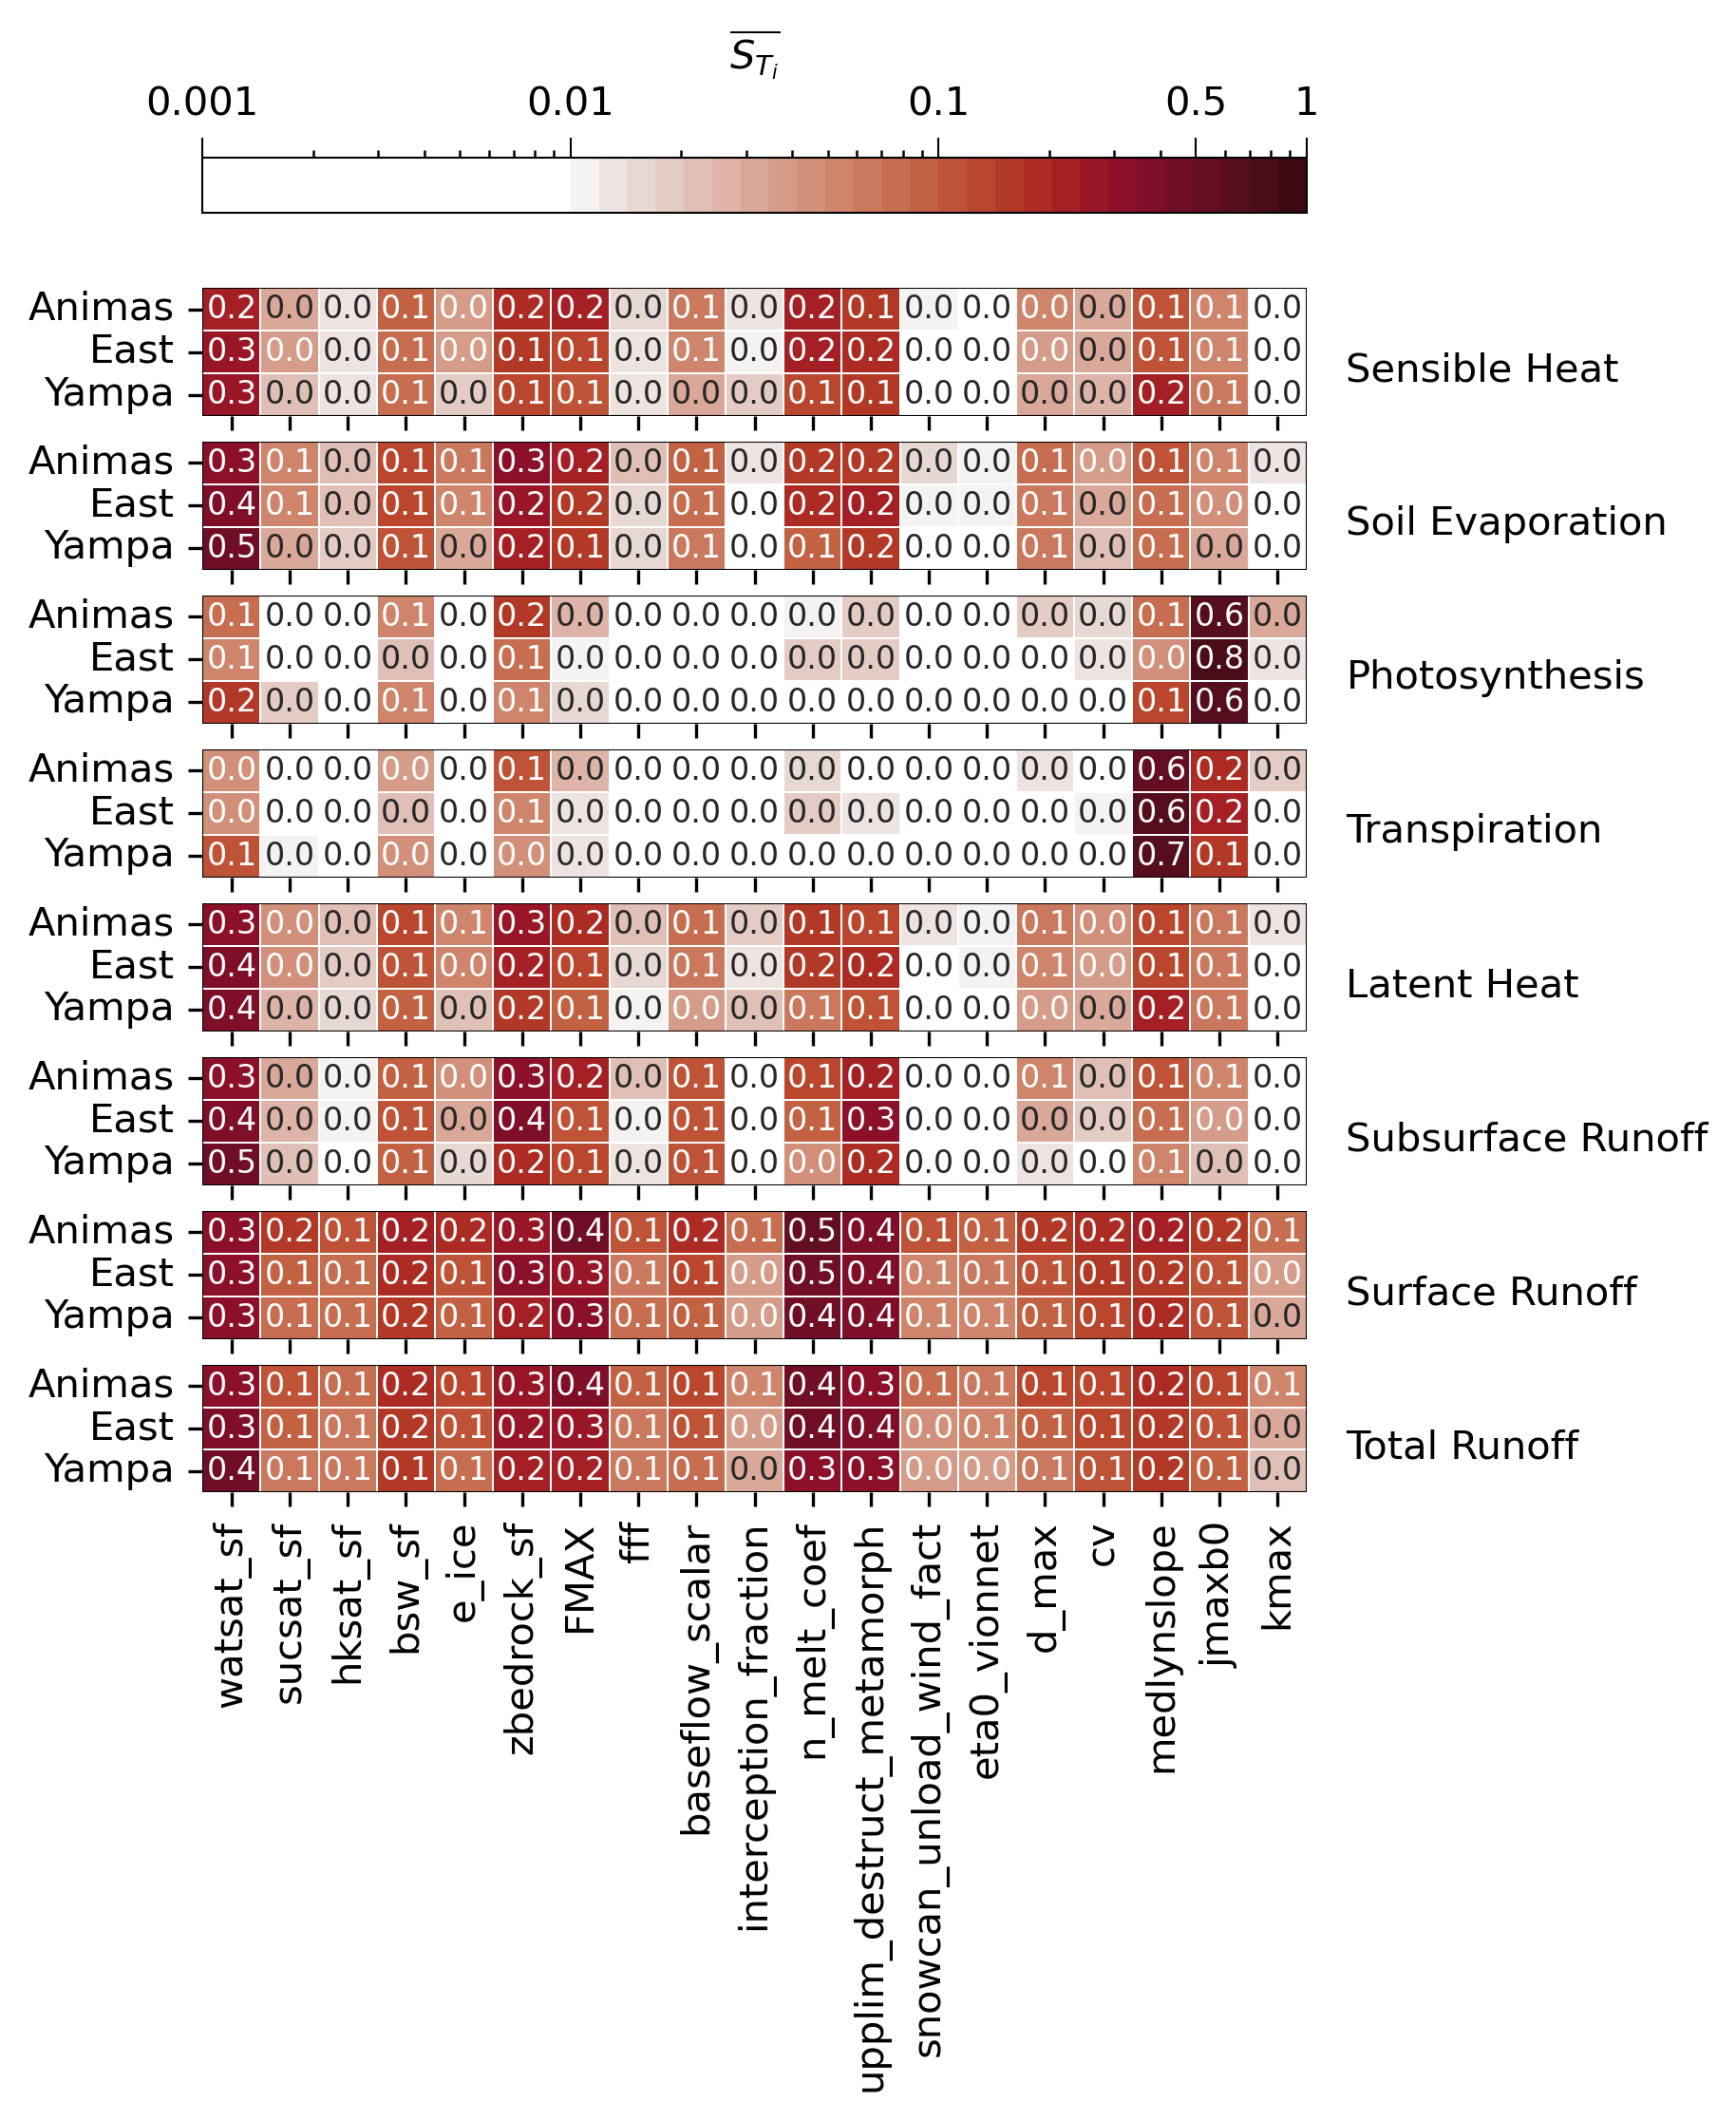

In [14]:
rows = ['FSH', 'QSOIL', 'FPSN', 'QVEGT', 'EFLX_LH_TOT', 'QDRAI', 'QOVER', 'QRUNOFF']#, 'beta', 'alpha']
rows_label = ['Sensible Heat', 'Soil Evaporation', 'Photosynthesis', 'Transpiration', 'Latent Heat', 'Subsurface Runoff', 'Surface Runoff', 'Total Runoff', r'$\beta$', r'$\alpha$']
nrows = len(rows)

norm = mpl.colors.LogNorm(vmin=0.001, vmax=1)
ticks = [0.001,0.01,0.1,0.5,1]
cbar_dict = dict(ticks=ticks, location='bottom', norm=norm)

fig, axes = plt.subplots(nrows,1,figsize=(5,nrows-1), dpi=300)
for i in range(nrows):
    dfi = dfplot_dict[rows[i]]
    sa = dfi.pivot(index="basin", columns="parameter", values="STi")
    sa = sa.loc[:, names_ordered]
    annot_data = sa.values
    annot_data = np.where(annot_data>0.01, np.round(annot_data,1), '')
    ylabel = rows_label[i]
    
    ax = axes[i]
    g1 = sns.heatmap(sa, vmin=0, vmax=1, linecolor='white', linewidth=.1, 
                     annot=True, fmt=".1f",
                     cbar=False, ax=ax, norm=norm, cmap=mymap, clip_on=False,
                     cbar_kws=cbar_dict, annot_kws={"size":8})
    # g1 = sns.heatmap(sa, vmin=0, vmax=1, cbar=False, ax=ax)
    g1.set(xlabel=None, ylabel=None, xticklabels=[]);
    ax.set_ylabel(ylabel, rotation=0, horizontalalignment='left', labelpad=10)
    ax.yaxis.set_label_position("right")
    # ax.get_yaxis().set_label_coords(1.1,0.7)
    ax.axhline(y=0, color='k',linewidth=.5)
    ax.axhline(y=3, color='k',linewidth=.5)
    ax.axvline(x=0, color='k',linewidth=.5)
    ax.axvline(x=sa.shape[1], color='k',linewidth=.5)

axes[-1].set_xticklabels(names_ordered);

cbar = fig.colorbar(g1.axes.collections[0], ax=axes, ticks=ticks, location='top', norm=norm)
cbar.set_ticklabels(ticks)
cbar.ax.tick_params(width=.5, length=5)
cbar.ax.set_xlabel(r'$\overline{S_{T_i}}$')
cbar.outline.set_linewidth(.5)
cbar.dividers.set_linewidth(.1);

## Variance-average Si timeseries

In [20]:
param_idx = np.array([0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]) # remove om_frac_sf
param_names = df_params.index
# basins = ['Yampa River', 'East River', 'Animas River']
basins = ['Yampa', 'East', 'Animas']
cols = ['basin','parameter','STi']
metrics = ['alpha','beta', 'sigma', 'rratio']
k = param_idx.size
nrow = k * len(basins)

In [22]:
timeplot_dict = {}
for i, tag in enumerate(('yampa','east','animas')):
    sdata = sa_dict[tag]
    vdata = vartot_dict[tag]
    sweighted = (sdata*vdata).groupby('time.dayofyear').sum()/vdata.groupby('time.dayofyear').sum()
    timeplot_dict[tag] = sweighted
    print(tag)

yampa
east
animas


In [24]:
names_ordered = ['watsat_sf', 'sucsat_sf', 'hksat_sf', 'bsw_sf', 'e_ice', 'zbedrock_sf', 'FMAX', 'fff',
                 'baseflow_scalar', 'interception_fraction', 'n_melt_coef', 'upplim_destruct_metamorph', 
                 'snowcan_unload_wind_fact', 'eta0_vionnet', 'd_max', 'cv', 'medlynslope', 'jmaxb0', 'kmax']
params_originalorder = ['watsat_sf', 'sucsat_sf', 'zbedrock_sf', 'bsw_sf', 'hksat_sf', 'om_frac_sf', 'e_ice', 'FMAX', 'fff', 'baseflow_scalar',
 'interception_fraction', 'd_max', 'cv', 'medlynslope', 'jmaxb0', 'kmax','upplim_destruct_metamorph', 
 'n_melt_coef', 'snowcan_unload_wind_fact' ,'eta0_vionnet']
ordered_idx = np.array([params_originalorder.index(names_ordered[pi]) for pi in range(19)])

In [25]:
colors = [
    '#120709', '#261214', '#4D2C29', '#78432C', '#B5754A', '#D1A38A', 
    '#553285', '#7B52AB', '#9768D1',
    '#F2DDEE',
    '#16193B', '#35478C', '#4E7AC7', '#7FB2F0',
    '#fde0dd', '#fa9fb5',
    '#C6E070', '#91C46C', '#287D7D'
]

In [30]:
titles = {'QRUNOFF':'Total Runoff','QOVER':'Surface Runoff','QDRAI':'Subsurface Runoff',
          'EFLX_LH_TOT':'Latent Heat', 'QVEGT':'Transpiration', 'QSOIL':'Soil Evaporation'
         }
units = {'QRUNOFF':'V (mm d$^{-1}$)$^{2}$','QOVER':'V (mm d$^{-1}$)$^{2}$','QDRAI':'V (mm d$^{-1}$)$^{2}$',
          'EFLX_LH_TOT':'V (Wm$^{-2}$)$^{2}$', 'QVEGT':'V (mm d$^{-1}$)$^{2}$', 'QSOIL':'V (mm d$^{-1}$)$^{2}$'
         }

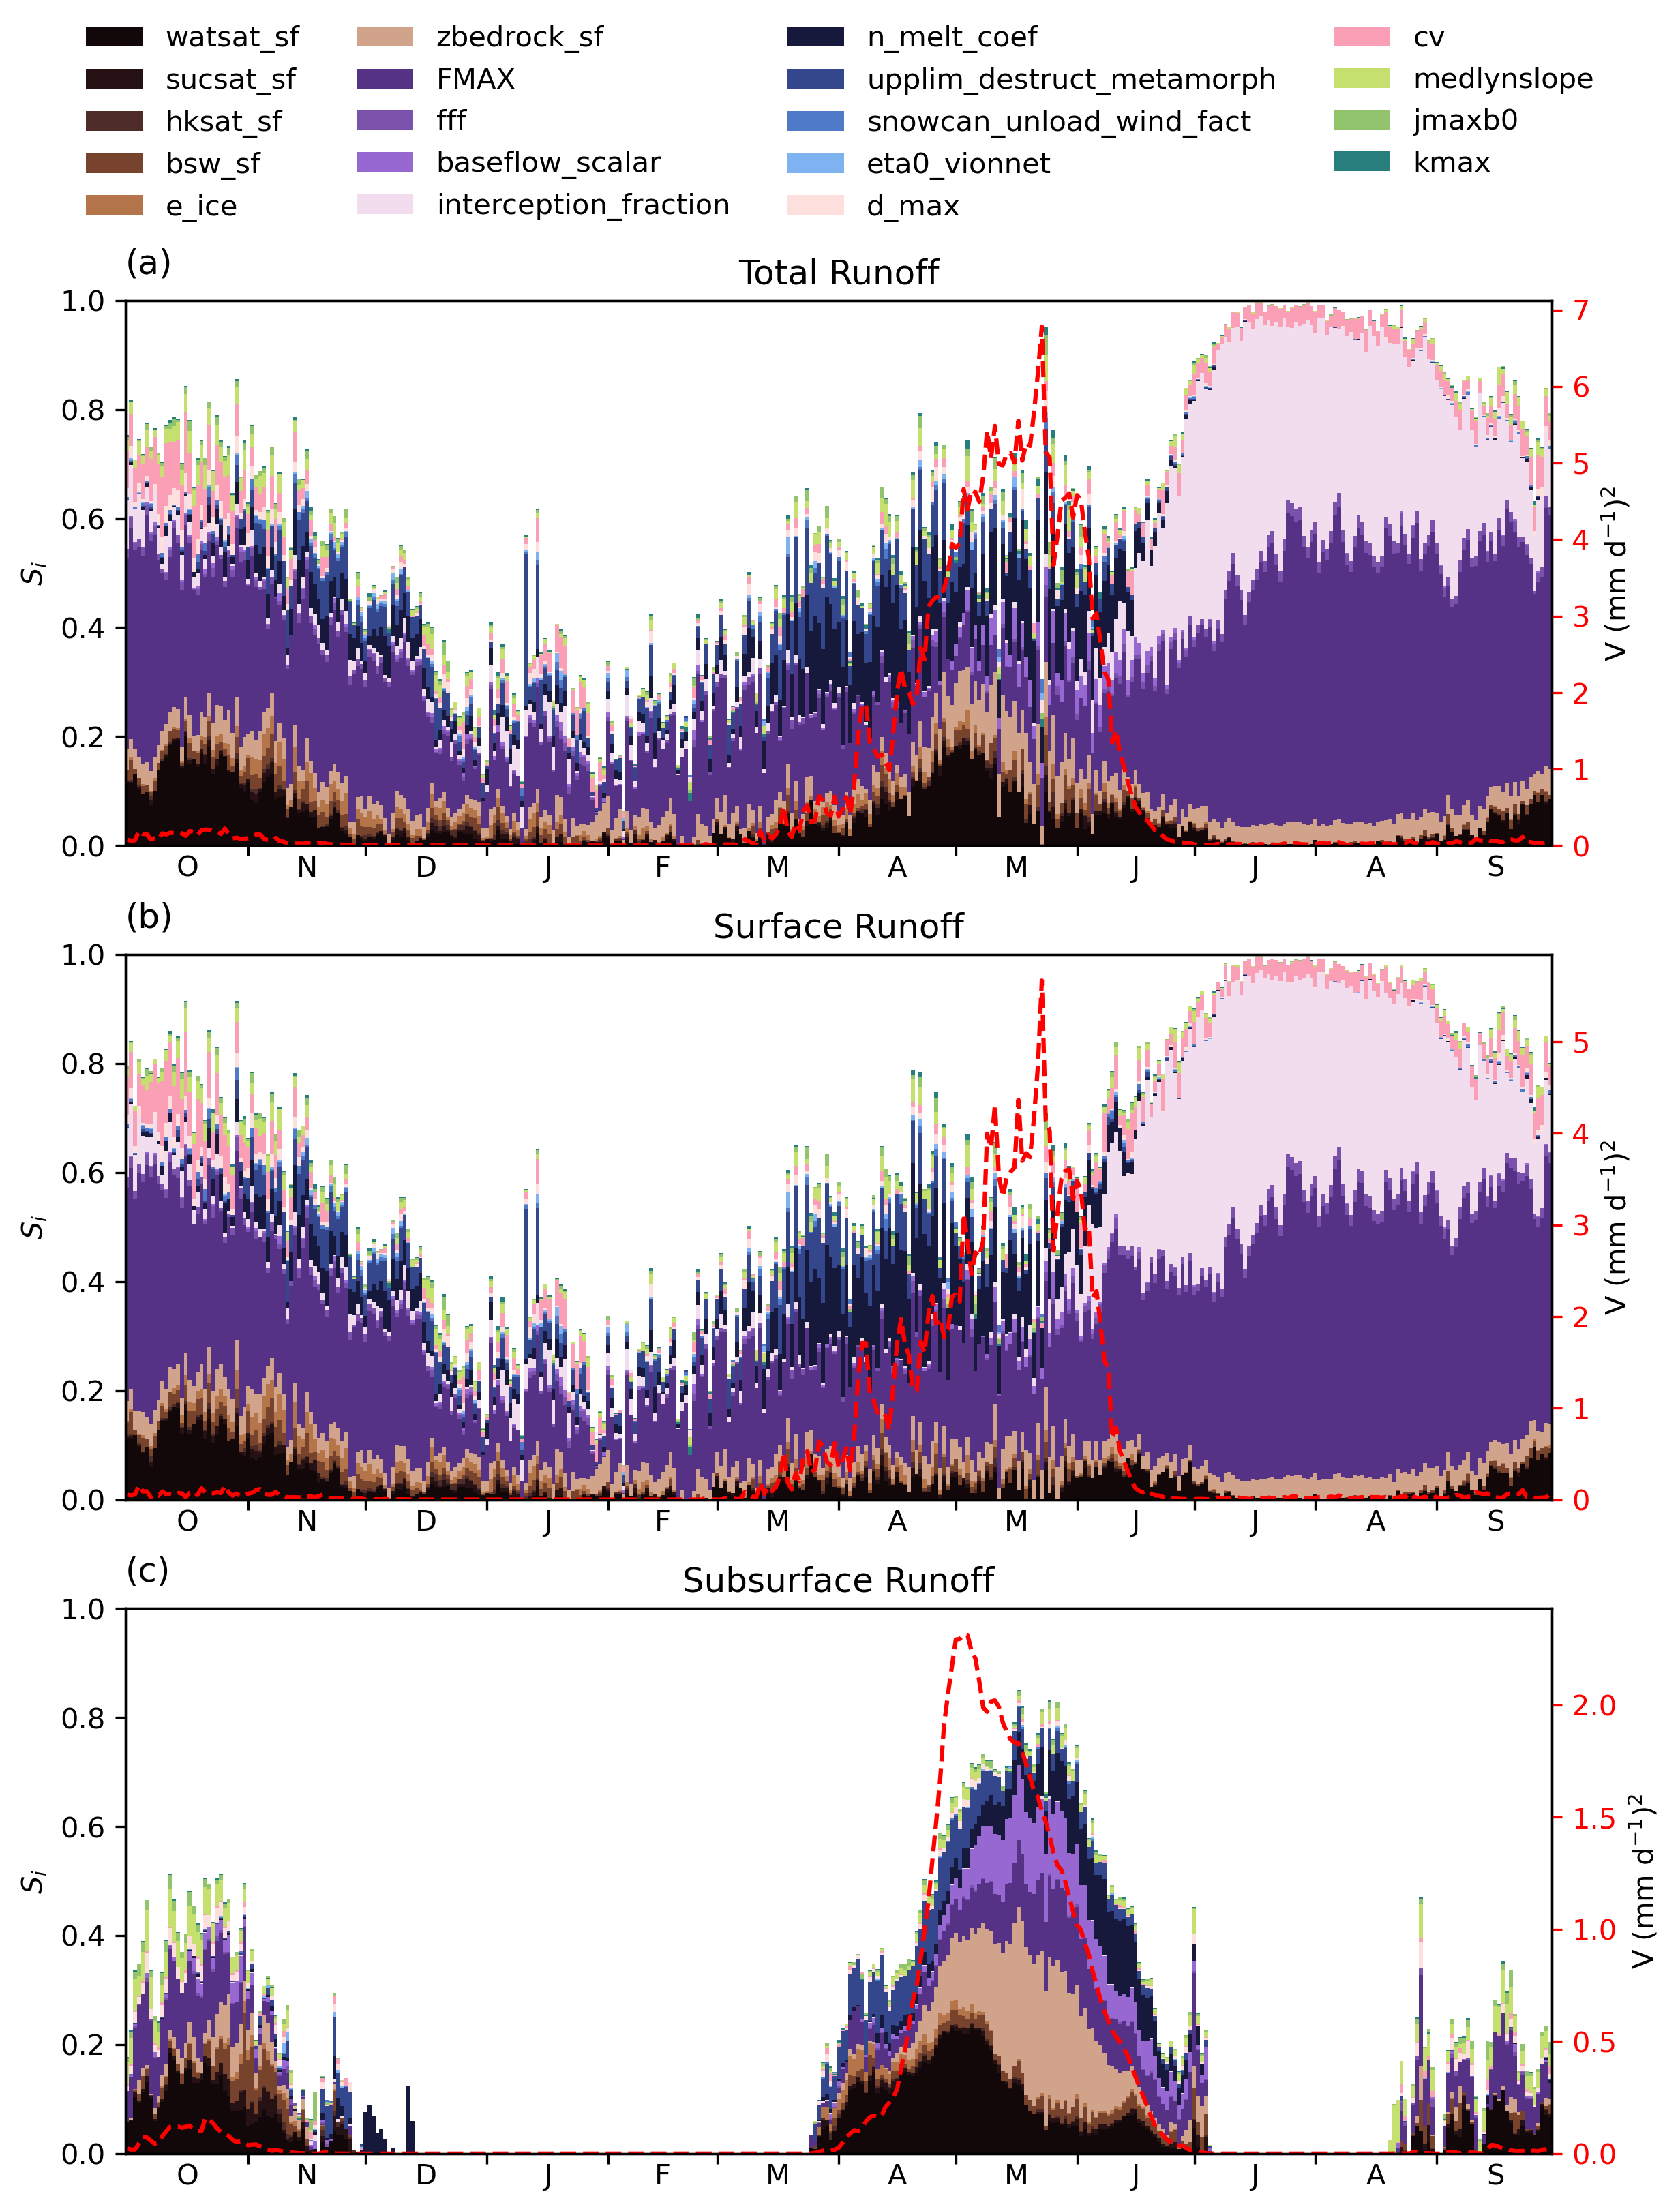

In [43]:
tag = 'animas'
si = 1 # Sti or Si
fig, axes = plt.subplots(3,1, figsize=(9,12), dpi=300)
monthlength = np.array([31,30,31, 31,28,31,30,31,30,31,31,30])
t = np.arange(365)
ti = np.hstack([t[273:],t[:273]])
v_doy = vartot_dict[tag].groupby('time.dayofyear').mean()
# for i, var in enumerate(['EFLX_LH_TOT','QVEGT','QSOIL']):
for i, var in enumerate(['QRUNOFF', 'QOVER', 'QDRAI']):
    St = timeplot_dict[tag][var][:, ordered_idx][ti][:,:,si,0]
    # St = St.clip(0)
    npara = ordered_idx.size
    ax = axes[i]
    twin1 = ax.twinx()
    # twin2 = ax.twinx()
    # twin2.spines.right.set_position(("axes", 1.14))
    for pi in range(npara):
        c = colors[pi]
        p2 = ax.bar(t, St[:, pi], 1, color=c,
             bottom=np.sum(St[:, 0:pi],axis=1), label=names_ordered[pi])

    v = v_doy[var][:,0][ti]
    if var in ['QVEGT','QSOIL','QRUNOFF', 'QOVER', 'QDRAI']:
        v = v*(24*60**2)**2
    # if var in ['EFLX_LH_TOT']:
        # v = v*(24*60**2)**2 / (2.45*10**6)**2
    p1, = twin1.plot(t, v, c='r', ls='--')
    twin1.set_ylabel(units[var])
    twin1.tick_params(axis='y', colors=p1.get_color())
    twin1.set_ylim(0)
    # ax.set_ylabel(r'$S_{T_i}$')
    ax.set_ylabel('$S_i$')
    ax.set_ylim(0,1)
    ax.set_xticks(np.cumsum(monthlength))
    ax.set_xticklabels('')
    ax.set_xticks((monthlength*1.0/2.)+np.cumsum(np.append(0,monthlength)[0:12]), minor=True)
    ax.set_xticklabels(['O','N','D', 'J','F','M','A','M','J','J','A','S',], minor=True);
    ax.tick_params('x',which='minor',length=0)
    ax.margins(x=0)
    ax.set_title(titles[var])

    if i==0:
        fig.legend(loc='upper center', ncol=4, frameon=False)
    ll = list('abcde')
    ax.annotate('(%s)'%ll[i],(0,1.05), xycoords='axes fraction', fontsize=12)

## Runoff climate sensitivity vs Sti 

In [77]:
param_idx = np.array([0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]) # remove om_frac_sf
param_names = df_params.index
basins = ['Yampa', 'East', 'Animas']
k = param_idx.size
nrow = k * len(basins)
cols = ['basin','parameter','r_runoff_ratio','r_surface_runoff_ratio', 'r_evaporation_ratio',
       'runoff_part','surface_runoff_part','plant_part','soil_storage_part','subsurface_runoff_part', 'evap_part']
corrplot_dict = {}
for ci, m in enumerate(('alpha','beta')):
    dfi = pd.DataFrame(np.full((nrow, len(cols)), np.nan), columns=cols)
    for i, tag in enumerate(('yampa','east','animas')):
        for j, ki in enumerate(param_idx):
            yy = arr_dy[i,ki,ci]
            corr = []
            for mi in range(3+6):
                xx = arr_dy[i,ki,2:][mi]
                corr.append(np.corrcoef(xx, yy)[0,1])
            dfi.iloc[j+(k*i), :] = [basins[i], param_names[ki], *corr]
    corrplot_dict[m] = dfi

In [78]:
metricfile = '/glade/work/elkoukah/inputs/params/param_ens_ucrb_headwaters/headwaters_singlept/variance/ens_p_part_SA.nc'
sa_part = xr.open_dataset(metricfile)
si = 0 # Sti
cols = ['basin','parameter', 'runoff_part','surface_runoff_part','plant_part','soil_storage_part','subsurface_runoff_part', 'evap_part']
sa_part_dict = {}
dfi_weights = pd.DataFrame(np.full((nrow, len(cols)), np.nan), columns=cols)
for i, tag in enumerate(('yampa','east','animas')):
    for j, ki in enumerate(param_idx):
        yy = sa_part[tag][ki,si].data.tolist()
        dfi_weights.iloc[j+(k*i), :] = [basins[i], param_names[ki], *yy]

In [35]:
param_idx = np.array([0,  1,  2,  3,  4,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]) # remove om_frac_sf
param_names = df_params.index
basins = ['Yampa', 'East', 'Animas']
k = param_idx.size
nrow = k * len(basins)
cols = ['basin','parameter', 'alpha', 'beta']
df_corr = pd.DataFrame(np.full((nrow, len(cols)), np.nan), columns=cols)
for i, tag in enumerate(('yampa','east','animas')):
    for j, ki in enumerate(param_idx):
        xx = arr_dparam[i,ki,0]
        yy1 = arr_dy[i,ki,0]
        yy2 = arr_dy[i,ki,1]
        df_corr.iloc[j+(k*i), :] = [basins[i], param_names[ki], np.corrcoef(xx, yy1)[0,1], np.corrcoef(xx, yy2)[0,1]]

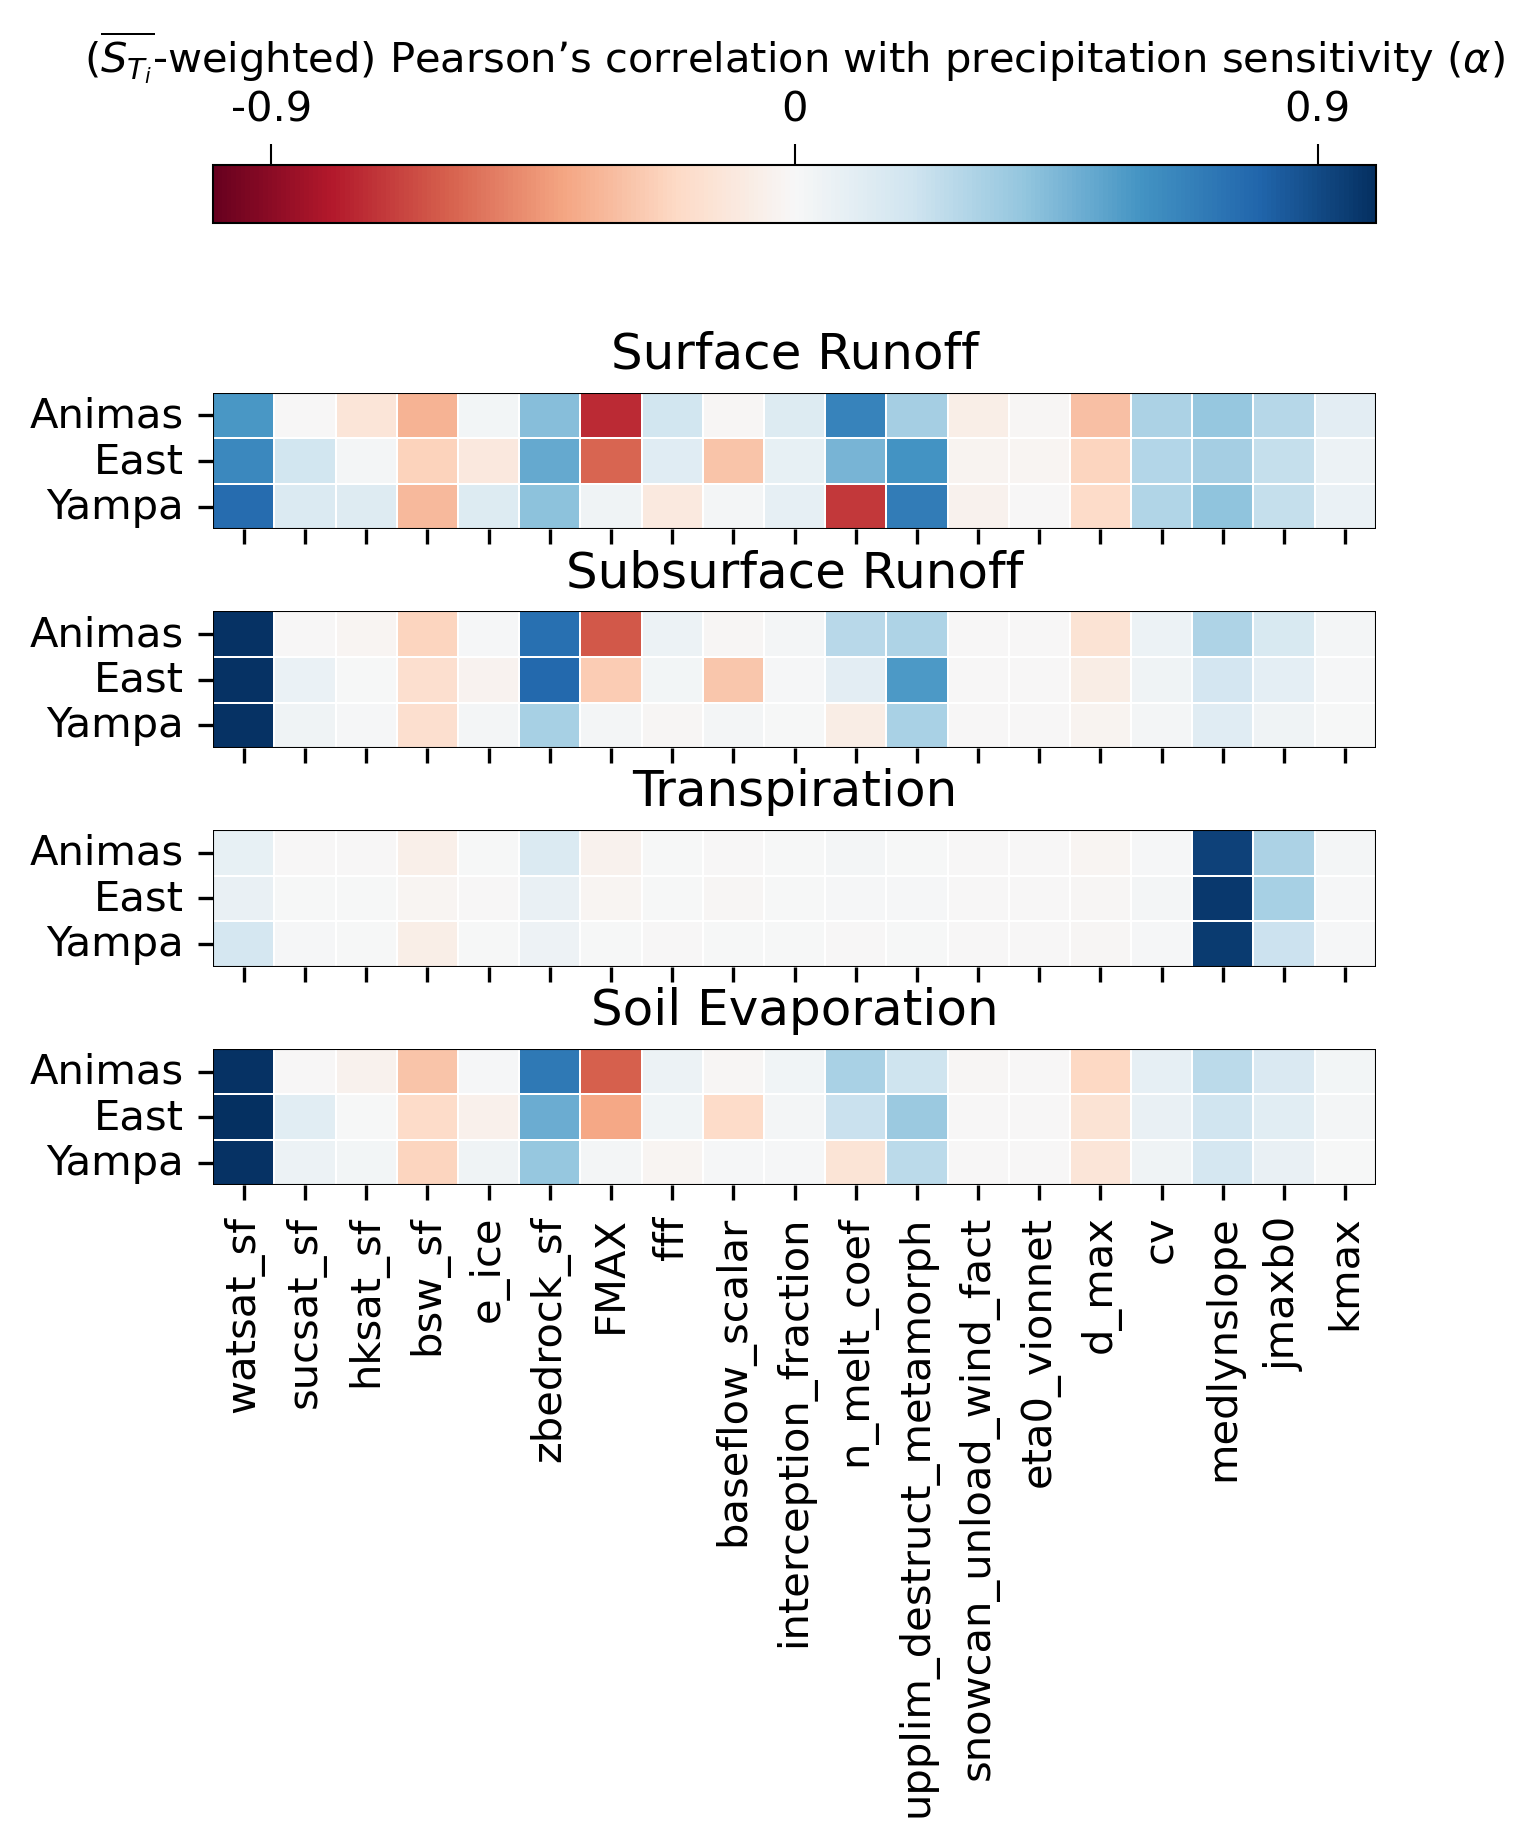

In [42]:
rows = ['QOVER', 'QDRAI', 'QVEGT', 'QSOIL']
# rows_label = ['Runoff partitioning','Surface runoff partitioning', 'Canopy partitioning', 'Storage partitioning']
rows_label = ['Surface Runoff', 'Subsurface Runoff', 'Transpiration', 'Soil Evaporation']
nrows = len(rows)

norm = mpl.colors.Normalize(vmin=-1, vmax=1)
mycmap = mpl.cm.get_cmap('RdBu')
ticks = [-.9, 0, .9]
cbar_dict = dict(ticks=ticks, location='bottom', norm=norm)

for j, m in enumerate(('alpha','beta')):
    fig, axes = plt.subplots(nrows,1,figsize=(5,5), gridspec_kw={'hspace':0.6}, dpi=300)
    for i in range(nrows):
        corr = df_corr.pivot(index="basin", columns="parameter", values=m)
        corr = corr.loc[:, names_ordered]
        dfi = dfplot_dict[rows[i]]
        sa = dfi.pivot(index="basin", columns="parameter", values="STi")
        weight = sa.loc[:, names_ordered]
        weight = (weight.T/weight.max(axis=1)).T
        corr_weighted = corr*weight
        ylabel = rows_label[i]
        
        ax = axes[i]
        g1 = sns.heatmap(corr_weighted, vmin=0, vmax=1, linecolor='white', linewidth=.1, 
                         annot=False, fmt=".1f",
                         cbar=False, ax=ax, norm=norm, cmap=mycmap, clip_on=False,
                         cbar_kws=cbar_dict, annot_kws={"size":7})
        g1.set(xlabel=None, ylabel=None, xticklabels=[]);
        ax.set_title(ylabel)
        ax.yaxis.set_label_position("right")
        # ax.get_yaxis().set_label_coords(1.1,0.7)
        ax.axhline(y=0, color='k',linewidth=.5)
        ax.axhline(y=3, color='k',linewidth=.5)
        ax.axvline(x=0, color='k',linewidth=.5)
        ax.axvline(x=19, color='k',linewidth=.5)
        
    axes[-1].set_xticklabels(names_ordered);
    cbar = fig.colorbar(g1.axes.collections[0], ax=axes, ticks=ticks, location='top', norm=norm, pad=.15)
    cbar.set_ticklabels(ticks)
    cbar.ax.tick_params(width=.5, length=5)
    if m=='beta':
        cbar.ax.set_xlabel(r'($\overline{S_{T_i}}$-weighted) Pearson’s correlation with temperature sensitivity ($\beta$)')
    else:
        cbar.ax.set_xlabel(r'($\overline{S_{T_i}}$-weighted) Pearson’s correlation with precipitation sensitivity ($\alpha$)')
    cbar.outline.set_linewidth(.5)
    cbar.dividers.set_linewidth(.1);
    # fig.savefig(f'figs/corr_sti_weight_param_climate_{m}_v3.jpg', bbox_inches='tight')
    break